# AmazonZero

In this notebook we'll explore on how to develop a AI for playing the game of amazons. The tactic is going to be to develop an AI using reinforcement learning. So we'll create an agent which consists of two parts:

1. A predictor: A neural network which predicts the winner: black or white (categorical), given some input data: Square States (categorical), Game States (categorical), Available squares white (integer), Available square black (integer).
2. An actor: A decision maker which monte carlo tree searches through all the possible moves and makes predictions on the board states for each deeper level. It then picks the tree which will result in the highest probability of a win for the acting side.

## The input data

We give AI three different sorts of input. 

### Square states
There are a total of four square states: [Empty, White Amazon, Black Amazon, Fire]. Which we'll encode as follows:

[E, WA, BA, F] = [0, 1, 2, 3] = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]

This is so the network picks up that these are categories and there is no certain order in them. This part of the input is fed seperately to the network.

### Board states
There are a total of four board states: [White selects, White shoots, Black selects, Black shoots]. Which we'll encode in the same way.

[Wse, Wsh, Bse, Bsh] = [0, 1, 2, 3] = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]

And again we will feed this in to the network seperately.

### Available squares white
We will also pass in a single node which contains the information about the number of available square for white. This value will be scaled between 0 and 1, and will be fed into the network seperately. 

### Available square black
We will also pass in a single node which contains the informat about the number of available squares for black. This value will be scaled betwee 0 and 1, and will be fed into the network seperately.

## The output data

The network will try to predict wether white will win or black will win.

White wins: [W] = [1] = [1, 0]
Black wins: [B] = [0] = [0, 1]

# Plan de Campagne

1. Random AI: We will create an AI which will play random moves.
- We still need to implement game end
- We need to implement the player on the server.


2. Smart AI: We will create a smart AI which monte carlo tree searches all possible moves and picks the path which will result in the most possible moves for the acting side

3. Neural Net AI: We will create two AI with an actor and predictor and let them play lots of games against eachother. After a certain amount of games we will update the nodes with the results of all the games in memory. NOTE: This AI uses a exploration and exploitation to explore. Where in the beginning there will be lots of exploration and once it has learned from a lot of previous games the AI will use more and more exploitation.

https://www.youtube.com/watch?v=RfNxXlO6BiA

In [2]:
import numpy as np
from amazonzero.board import Board
import matplotlib.pyplot as plt
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

TURN = ['white', 'black']

colormap = {'white': 1, 'black': 2}
class Board:
    """
    A board class of width x width with n_amazons for each side. 
    """
    def __init__(self, width, n_amazons):
        if width / n_amazons < 2: 
            raise ValueError("Not enough room for the Amazons. Use less amazons our create a bigger board.")
        self.width = width
        self.n_amazons = n_amazons
        self.matrix = self.create_board()
        self.turn = 'white'
        self.winner = None
        
    def create_board(self):
        matrix = np.zeros(shape=(self.width, self.width))
        for i in range(self.n_amazons):
            matrix[i][i] = 1
            matrix[self.width-i-1][self.width-i-1] = 2
        return matrix
    
    def plot_board(self):
        plt.imshow(self.matrix, cmap=ListedColormap(['white', 'beige', 'black', 'red']))
        plt.axis("off")
        plt.show()

    def available_squares(self, color='white'):
        """
        Calculates the number of available squares.


        :param color:
        :return:
        """
        pass
    
    def get_options(self, from_sq):
        row = from_sq[0]
        col = from_sq[1]
        options = []
        
        # to the right
        for j in range(col + 1, self.width):
            if board.matrix[row][j] == 0:
                options.append([row, j])
            else:
                break
                
        # to the left
        for j in range(col - 1, -1, -1):
            if board.matrix[row][j] == 0:
                options.append([row, j])
            else:
                break
                
        # down
        for i in range(row + 1, self.width):
            if board.matrix[i][col] == 0:
                options.append([i, col])
            else:
                break
        
        # up
        for i in range(row - 1, -1, -1):
            if board.matrix[i][col] == 0:
                options.append([i, col])
            else:
                break

        # upleft
        for offset in range(1, min(row, col) + 1):
            if board.matrix[row - offset][col - offset] == 0:
                options.append([row - offset, col - offset])
            else:
                break
            
        # upright
        for offset in range(1, min(row, board.width - col - 1) + 1):
            if board.matrix[row - offset][col + offset] == 0:
                options.append([row - offset, col + offset])
            else:
                break
                
        # downleft
        for offset in range(1, min(board.width - row - 1, col) + 1):
            if board.matrix[row + offset][col - offset] == 0:
                options.append([row + offset, col - offset])
            else:
                break
        
        # downright
        for offset in range(1, min(board.width - row - 1, board.width - col - 1) + 1):
            if board.matrix[row + offset][col + offset] == 0:
                options.append([row + offset, col + offset])
            else:
                break
        
        return options
        
    def next_turn(self):
        "Sets the board to the next turn"
        
        ix = TURN.index(self.turn)
        next_turn= TURN[(ix+1)%2]
        self.turn = next_turn
        
    def move(self, from_sq, to_sq):
        piece = self.matrix[from_sq[0], from_sq[1]]
        self.matrix[from_sq[0], from_sq[1]] = 0
        self.matrix[to_sq[0], to_sq[1]] = piece
    
    def shoot(self, sq):
        board.matrix[sq[0], sq[1]] = 3
        self.next_turn()
        
    def get_pieces(self, color):
        pieces = [[i, j] for i in range(0, self.width) for j in range(0, self.width) \
                  if self.matrix[i][j] == colormap.get(color)]
        return pieces
        
    def check_if_ended(self):
        pieces = self.get_pieces(self.turn)
        for piece in pieces:
            if len(self.get_options(piece)) > 0:
                return False

        self.winner = "white" if self.turn == "black" else "black"
        return True
        
    def next_board_states(self):
        pass
    
    
class RandomPlayer:
    def __init__(self, board, color):
        self.board = board
        self.color = color
        
    def move(self):
        # grab a white piece
        pieces = self.board.get_pieces(self.color)
        options = []  # (piece, option)

        
        for piece in pieces:
            options += [[piece, opt] for opt in self.board.get_options(piece)]

        choice = random.choice(options)
        self.board.move(choice[0], choice[1])

        # shoot
        shoot_options = self.board.get_options(choice[1])
        shoot_choice = random.choice(shoot_options)
        self.board.shoot(shoot_choice)

        
def play_a_game(board, player1, player2):
    turn = 0
    players = [player1, player2]
    
    end = False
    while not end:
        players[turn].move()
        turn = 1 - turn
        
        end = board.check_if_ended()
        
    print(board.matrix)
    print(f"Winner is {board.winner}")
    board.plot_board()

In [234]:
board = Board(4, 2)
p1 = RandomPlayer(board, 'white')
p2 = RandomPlayer(board, 'black')

board.matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]])

[[3. 3. 3. 2.]
 [1. 3. 1. 3.]
 [3. 3. 3. 3.]
 [2. 0. 0. 3.]]
Winner is black


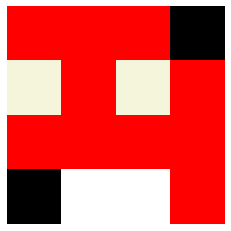

In [235]:
play_a_game(board, p1, p2)

In [199]:
p1.move()

In [196]:
p2.move()

In [197]:
board.matrix

array([[0., 0., 1., 0.],
       [0., 1., 3., 0.],
       [0., 0., 3., 0.],
       [0., 0., 2., 2.]])

In [200]:
board.turn

'black'

In [110]:
board.get_options([1,1])

[[1, 2], [1, 3], [1, 0], [2, 1], [3, 1], [0, 1], [0, 2], [2, 0]]

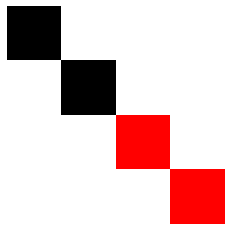

In [93]:
board.plot_board()

In [81]:
board.matrix

array([[1., 3., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]])

In [38]:
board.move([0,1], [3,3])

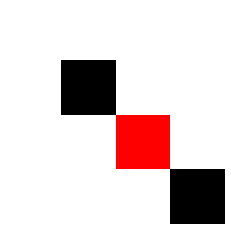

In [39]:
board.plot_board()